In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
cntry_cntry_df = pd.read_csv("..//..//..//data//Data//DerivedData//Derived//funding_source_target.csv")
cntry_cntry_df = cntry_cntry_df.pivot_table(
    index='source',columns='target', values='value', fill_value=0)
cntry_cntry_df.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1706.342726,0.0,0.000000,0.0,0.0,3.92619,0.0,1.997885,...,21.937491,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.5,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,20.581349,0.0,0.0,0.00000,0.0,2.650000,...,3.602381,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [3]:
cntry_out = cntry_cntry_df.sum(axis=1).reset_index(name="unitsout")
cntry_in = cntry_cntry_df.sum(axis=0).reset_index(name='unitsin')
cntry_in_out=cntry_in.merge(
    cntry_out, left_on="target",right_on="source",how="inner")
cntry_in_out.head()

,target,unitsin,source,unitsout
0,Afghanistan,95.035440,Afghanistan,23.0
1,Albania,207.108642,Albania,34.0
2,Algeria,4864.172289,Algeria,2607.0
3,Andorra,25.181734,Andorra,53.0
4,Angola,204.422412,Angola,76.0


In [3]:
pubs_author_null = pd.read_csv("pubs_author_shuffled.csv")
pubs_author_null['author_country']=pubs_author_null['author_country'].apply(literal_eval)
pubs_author_null.head()

,id,author_country
0,30507292,"[Turkey, Turkey]"
1,30574690,"[France, United States]"
2,30574691,[Russia]
3,30585095,"[Spain, Spain]"
4,30585097,"[Spain, Spain, Spain, Germany, Germany]"


In [4]:
pubs_funder_null = pd.read_csv('pubs_funder_shuffled.csv')
pubs_funder_null['funder_country']=pubs_funder_null['funder_country'].apply(literal_eval)
pubs_funder_null.head()

,id,funder_country
0,30507292,[Turkey]
1,30574690,"[United States, United States, United States, ..."
2,30574691,[Russia]
3,30585095,"[Spain, Spain, Spain, Spain]"
4,30585097,"[Spain, Spain, Spain]"


In [6]:
pubs_null=pubs_author_null.merge(pubs_funder_null, on="id")
pubs_null.head()

,id,author_country,funder_country
0,30507292,"[Turkey, Turkey]",[Turkey]
1,30574690,"[France, United States]","[United States, United States, United States, ..."
2,30574691,[Russia],[Russia]
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain]"
4,30585097,"[Spain, Spain, Spain, Germany, Germany]","[Spain, Spain, Spain]"


In [7]:
pubs_null['funding_units'] = pubs_null['funder_country'].apply(
    lambda x: len(x))
pubs_null.head()

,id,author_country,funder_country,funding_units
0,30507292,"[Turkey, Turkey]",[Turkey],1
1,30574690,"[France, United States]","[United States, United States, United States, ...",5
2,30574691,[Russia],[Russia],1
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain]",4
4,30585097,"[Spain, Spain, Spain, Germany, Germany]","[Spain, Spain, Spain]",3


In [8]:
def generate_null(data):
    cntry_cntry_explodelist = []
    for index, row in data.iterrows():
        units = row['funding_units']
        author_country = row['author_country']
        funding_country=row['funder_country']
        num_author = len(author_country)
        num_funder=len(funding_country)
        for author_c in author_country:
            for funder_c in funding_country:
                credit = units/(num_author*num_funder)
                templist = [funder_c,author_c, credit]
                cntry_cntry_explodelist.append(templist)
                
    cntry_cntry_null = pd.DataFrame(
        cntry_cntry_explodelist, columns=['source','target','value'])
    cntry_cntry_null = cntry_cntry_null.groupby(['source','target'])['value'].sum().reset_index()
    cntry_cntry_null = cntry_cntry_null.pivot_table(
        index='source',columns='target', values='value', fill_value=0)
    return cntry_cntry_null


In [10]:
def get_normedmatrix(indexlist, collist, actual_df, random_df):
    
    randomnormed_df = pd.DataFrame(
        index=indexlist,columns=collist)
    for ind, col in product(indexlist, collist):
        try:
            actual_value=actual_df.loc[ind,col]
        except:
            actual_value=0
        random_value=random_df.loc[ind,col]
        exp=actual_value/random_value
        randomnormed_df.loc[ind,col]=exp
    randomnormed_df = randomnormed_df.fillna(0)
    
    return randomnormed_df


In [9]:
pubs_null_matrix=generate_null(pubs_null)

In [13]:
cntry_cntry_df.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1706.342726,0.0,0.000000,0.0,0.0,3.92619,0.0,1.997885,...,21.937491,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.5,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,20.581349,0.0,0.0,0.00000,0.0,2.650000,...,3.602381,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [14]:
funderlist=cntry_cntry_df.index
authorlist=cntry_cntry_df.columns
pubs_null_normed=get_normedmatrix(
    funderlist, authorlist,cntry_cntry_df, pubs_null_matrix)

<ipython-input-10-13d4e271a30e>:11: RuntimeWarning: invalid value encountered in double_scalars
  exp=actual_value/random_value


In [5]:
pubs_null_normed=pd.read_csv("pubs_null_normed.csv", index_col=0)

In [6]:
import matplotlib.colors as colors
divnorm = colors.DivergingNorm(vmin=0, vcenter=1, vmax=13)

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


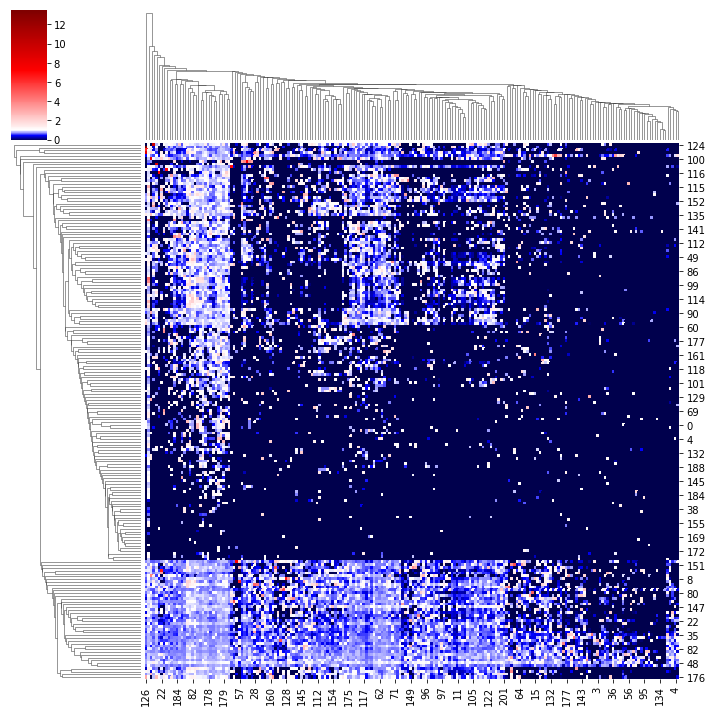

In [7]:
sns.clustermap(pubs_null_normed.values,norm=divnorm,cmap="seismic")

In [8]:
top20 = cntry_in_out.sort_values(
    by='unitsout',ascending=False).head(20).source

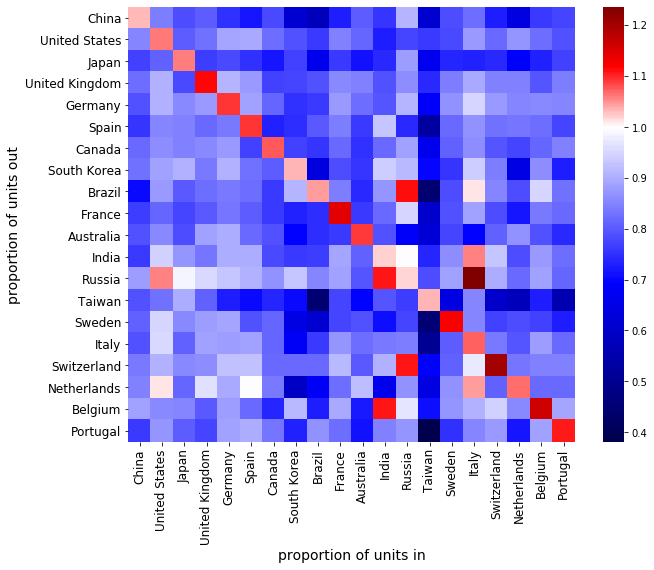

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pubs_null_normed.loc[top20,top20],norm=divnorm,cmap="seismic")
plt.ylabel("proportion of units out", fontsize=14)
plt.xlabel("proportion of units in", fontsize=14)
plt.tick_params(axis='both',labelsize=12)

In [19]:
pubs_null_normed.loc['China',pubs_null_normed.loc['China',:]>1]

target
Albania                            1.212902
Angola                             2.046784
Central African Republic           1.780822
China                              1.032367
Comoros                            1.102041
El Salvador                        1.090909
Federated States of Micronesia     1.624057
French-Polynesia                   1.622413
Ghana                              1.045147
Grenada                            2.502539
Kyrgyzstan                         1.007996
Lesotho                            1.090909
Liechtenstein                      1.338108
Macedonia                          1.439755
Malawi                             1.223302
Maldives                           2.250000
Nauru                              4.266667
Nicaragua                          2.099394
Qatar                              1.098992
Saudi Arabia                       1.047500
South Sudan                        1.562500
Sudan                              1.250585
Yemen                    